# Install and Import Libraries

Install the following libraries if they are not already installed in this enivronement.

### To get Torch for Jetson Nano run following code:

``` bash
wget https://nvidia.box.com/shared/static/p57jwntv436lfrd78inwl7iml6p13fzh.whl -O torch-1.8.0-cp36-cp36m-linux_aarch64.whl
```

### To get JetCam download from GitHub and install (run in your environment):
``` bash
git clone https://github.com/NVIDIA-AI-IOT/jetcam
cd jetcam # I downloaded file in recylcing folder
sudo python3 setup.py install
```

In [1]:
# Uncomment and run the appropriate command for your operating system, if required
# !pip install numpy==1.19.4 # Version that comes with Nano
# !pip install pandas
# !sudo apt-get install python3-pip libopenblas-base libopenmpi-dev 
# !pip3 install Cython
# !pip3 install numpy torch-1.8.0-cp36-cp36m-linux_aarch64.whl
# !pip install opencv-python==4.1.1
# !pip install torchvision==0.10.0 # this is the one that's compatibile with our version of torch
# !pip install sklearn pillow tqdm
# !pip install matplotlib
# !pip install tqdm
# !pip install seaborn

I removed torch wheel after pip install.

### Load Libraries

<span style="color:red">Make sure to note where your jetcam file is</span>.

In [4]:
# Data manipulation packages
import numpy as np
import pandas as pd
import os
import shutil

# Graphing
import matplotlib.pyplot as plt
# import seaborn as sns

# Torch Packages
import torch# might want have a different version
from torch.utils.data import DataLoader
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

# For constructing neural networks
import torch.nn as nn
import torch.nn.functional as F

# other
import ipywidgets
from IPython.display import display
from tqdm import tqdm_notebook as tqdm
import random
import copy
import time

torch.__version__

'1.8.0'

In [5]:
# Constant Variables
BATCH_SIZE = 15 # to load the data in batches (this will look at 10 images with each iteration)
IMG_WIDTH, IMG_HEIGHT = 224, 224


# Get the directory of our images
DATA_DIR = "./data/mc_model_training/images/"

#The classes for this data set
CATEGORIES = [i for i in os.listdir(DATA_DIR) if "." != i[0]] # to ignore hidden files

print("The categories: ", CATEGORIES)
print("The number of categories:", len(CATEGORIES))

The categories:  ['trash', 'recycle', 'biodegradable', 'e_waste']
The number of categories: 4


In [6]:
# Checks if we have CUDA capabilities and if we don't then use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Transform the data

The first thing to do is to check the what classes there are.
### Data from: https://www.kaggle.com/asdasdasasdas/garbage-classification

In [7]:
len(os.listdir(DATA_DIR + CATEGORIES[0]))
total_count = 0
for i in range(len(CATEGORIES)):
    
    number_images = len(os.listdir(DATA_DIR + CATEGORIES[i]))
    total_count +=  number_images           
    print(f"{CATEGORIES[i]}-count: {number_images}")

print("\nTotal Images:", total_count)

trash-count: 137
recycle-count: 2571
biodegradable-count: 30506
e_waste-count: 549

Total Images: 33763


In [8]:
images = []
categoryLabel = []

for classItem in os.listdir(DATA_DIR):
    for image in os.listdir(DATA_DIR + classItem):
        images.append(image)
        categoryLabel.append(classItem)

data_df = pd.DataFrame({"Image": images, "Label": categoryLabel})

In [9]:
data_df

,Image,Label
0,trash25.jpg,trash
1,trash71.jpg,trash
2,trash114.jpg,trash
3,trash73.jpg,trash
4,trash44.jpg,trash
...,...,...
33758,625.jpeg,e_waste
33759,IMG-20200328-WA0025.jpg,e_waste
33760,2.jpeg,e_waste
33761,483.jpg,e_waste


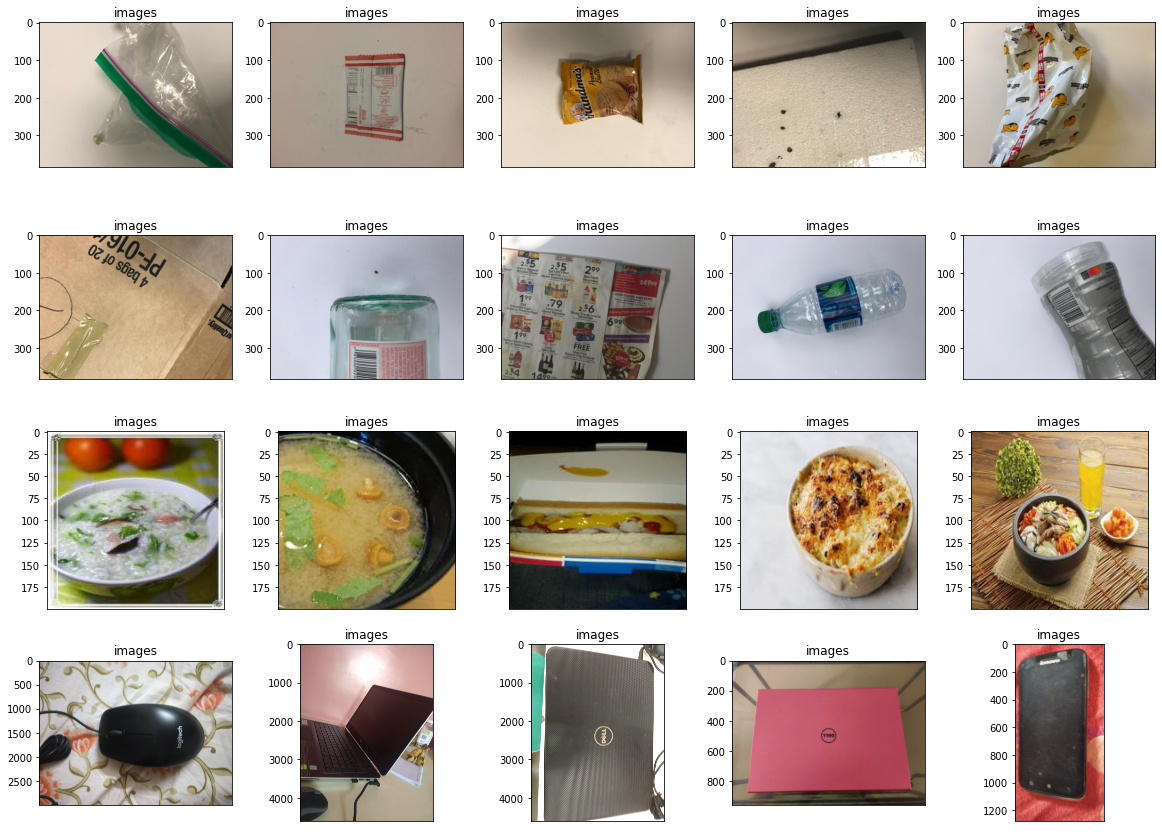

In [10]:
fig = plt.figure(figsize=(20, 15))

number_cols = 5
nbyn = len(CATEGORIES) * number_cols

img_path_list = []
for category in CATEGORIES:
    j = 0
    
    while j < number_cols:
        tmp_lst = list(data_df["Image"][data_df["Label"] == category])
        img = random.choice(tmp_lst)
        img_path = DATA_DIR + category + "/" + img
        img_path_list.append(img_path)
        j += 1
    
for i in range(1, nbyn + 1):
    plt.subplot(len(CATEGORIES), number_cols, i)
    tmp_img = plt.imread(img_path_list[i - 1])
    title = img_path_list[i - 1].split("/")[3]
    plt.imshow(tmp_img)
    

    #hidex-axis
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    
    plt.title(title)

plt.show()

## Preprocessing

### Split the data into test and training folders
We want to first split our data into training and testing data files - it's recommended that 80% of the data be used for training and 20% for testing.

<span style="color:red">You'll get an error if a training or test dataset exist</span>.

In [11]:
import shutil

def make_test_and_train_data(data_folder, classes, train_ratio=0.8):
    foldersOfMain = os.listdir(data_folder)
    image_loc = data_folder + "testing_data"
    
    if os.path.isdir(image_loc):
        print("Folders already exist")
        print("*"* 50)
        
        test_dir = data_folder + f"testing_data/test/"
        train_dir = data_folder + f"testing_data/train/"
        
        for item in classes:
            train_images = os.listdir(train_dir + item)
            test_image = os.listdir(test_dir + item)
            
            print(f"{item} =>train: {len(train_images)} | test: {len(test_image)}")
            
        
        return test_dir, train_dir
    
    
    for item in classes:
        # Shuffle the images
        images_list = os.listdir(f"data/mc_model_training/images/{item}")
        random.shuffle(images_list) # shuffle the data

        #Split the images into training and test data
        test_index = int(len(images_list) * 0.8) # index for 80% of the data
        train_images,test_image = np.split(images_list, [test_index])
    
        # Make the files
        images_list = os.listdir(f"data/mc_model_training/images/{item}")
        if "testing_data" not in foldersOfMain:
            os.makedirs(data_folder + f"testing_data/train/{item}")
            os.makedirs(data_folder + f"testing_data/test/{item}")
        
        # Copy over the images
        images_path = f"data/mc_model_training/images/{item}/"
        
        test_dir = data_folder + f"testing_data/test/"
        train_dir = data_folder + f"testing_data/train/"
        
        print(f"{item} =>train: {len(train_images)} | test: {len(test_image)}")
        for name in test_image:
           shutil.copy(images_path + name, test_dir + f"{item}/{name}")
        
        for name in train_images:
            shutil.copy(images_path + name, train_dir + f"{item}/{name}")
        
    return test_dir, train_dir


In [12]:
classItems = [i for i in os.listdir(DATA_DIR) if "." != i[0]] # to ignore hidden files
TEST_DIR, TRAIN_DIR = make_test_and_train_data("./data/mc_model_training/", classItems)

Folders already exist
**************************************************
trash =>train: 109 | test: 28
recycle =>train: 2056 | test: 515
biodegradable =>train: 24404 | test: 6102
e_waste =>train: 439 | test: 110


### Transform the Data
 
We need to transform our data from an array datastructure to a tensor datastructure.

<strong>For example we can do the follwing</strong>:
1. Resize -> to be sure that all the images are of the same size and that they match the size or our camera images
2. Random Horizontal and Vertical flip -> to add variation in our data set.
3. Transform our data to tensor datastructure.

In [13]:
tranformers = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(), # Horizontally flip the given image randomly with a given probability. (p=0.5)
    transforms.RandomVerticalFlip(), # Vertically flip the given image randomly with a given probability. (p=0.5)
    transforms.ToTensor() # Convert a PIL Image or numpy.ndarray to tensor.
])

# Create Training and Test Data sets
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=tranformers)
test_dataset = torchvision.datasets.ImageFolder(TEST_DIR, transform=tranformers)

If we randomly check the dataset, we see that the img shape is whose size is 224 x 224px and has 3 color channels (RGB). 

The print output is => [RGB, img_width, img_height], class (i.e. cardboard)

In [14]:
img, label = train_dataset[0] # Grab a sample element - each element is a tuple.

print(img.shape, label)

torch.Size([3, 224, 224]) 0


In [15]:
print(train_dataset.classes)

['biodegradable', 'e_waste', 'recycle', 'trash']


## Train and Validate the Data

Now that we have our tensor data structures, we can move on to training our data.

<h4>The data is split in two parts:</h4>

1. <strong> Training Set </strong> - this will be used to train the model (i.e. compute the loss and adjust the weights).

2. <strong> Test Set </strong> - used to compare the results for any models that we might use.

<strong>DataLoader</strong> Combines a dataset and a sampler, and provides an iterable over the given dataset.

<em>Parameters</em>:
* <strong>dataset</strong>: dataset from which to load the data.
* <strong>batch_size</strong>: how many samples per batch to load
* <strong>shuffle</strong>: set to True to have the data reshuffled at every epoch
* <strong>num_workers</strong>: how many subprocesses to use for data loading. 

In [16]:
num_GPU = 4 * torch.cuda.device_count()
train_dl = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dl = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [17]:
from torchvision.utils import make_grid

def show_batch(dl, nrows=3):
    i = 1
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        i += 1
        if i > nrows:
            break

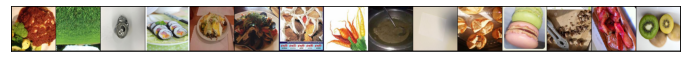

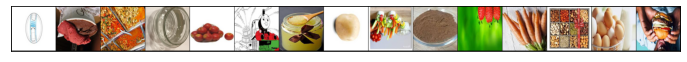

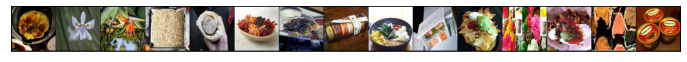

In [18]:
show_batch(train_dl)

### Defining the Model (Convolutional Neural Network)

##### What is a convolutional network?
It’s a deep neural network that works on that works on visual data (i.e. images)

Takes an image as an input → performs 2D or 3D convolutional operations on the image with several filters (aka kernals).

<div>
    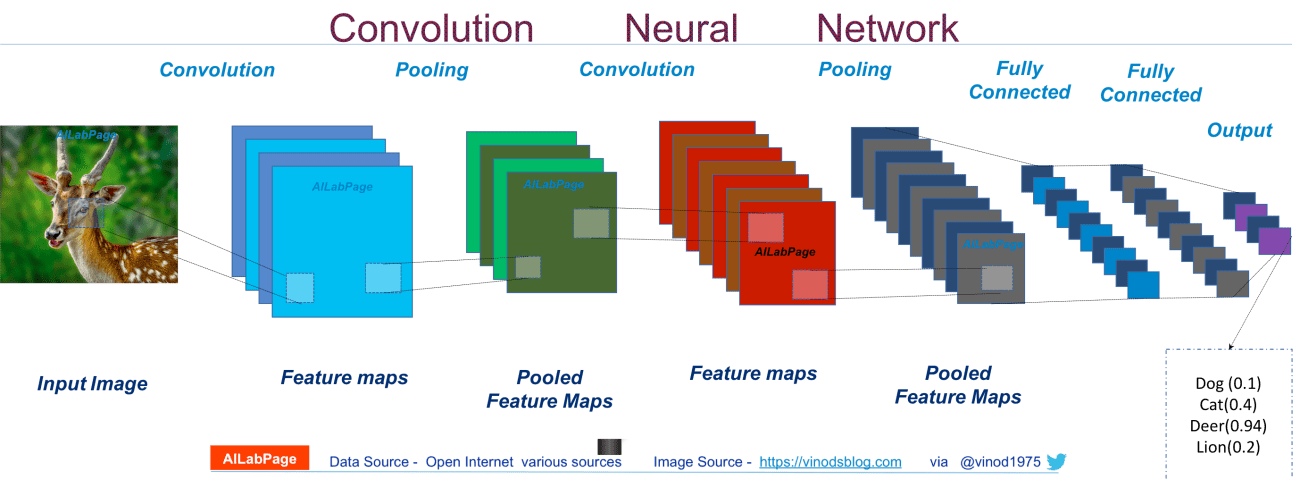
</div>

#### Linear Transformation - <span style="color:red">Not quite sure if this is what happens here </span>.

Converts an n pixels x n pixels image into a column of n * n input nodes and then connect the input nodes to a hidden layer (each connection has a weight that we estimate via propigation). 

This method doesn't scale very well and might not perform well if the images are shifted. Also has a hard time with correalated pixels (pixels that are near similarly colored pixels - browns next to other brownish pixels).


#### 2D Convolution - Conv2d
<strong>Work well because</strong>:
1. Reduce the number of input nodes.
2. tolerate small shifts in where the pixels are.
3. Take advantage of correlations we observe in complex images.

<strong>How it works? </strong>
* First a filter (aka kernal is applied to the image - this is just a maller sqaure that is typical 3 pixels x 3 pixels
<div>
    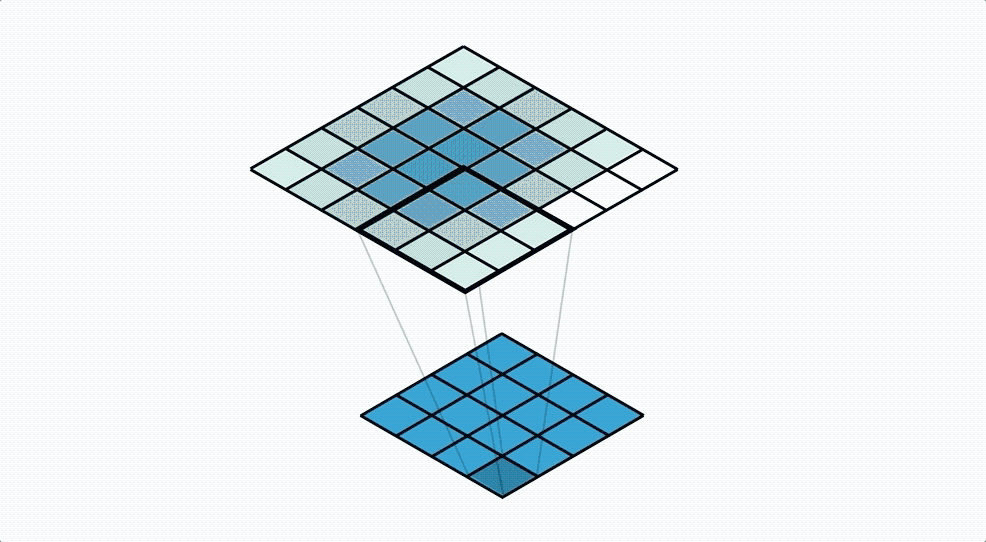
</div>
* And then multiple each overlapping pixel and then add the products together to get the dot product.
*  Then add a bias term to the kernal output and put the final value in a feature map.
* Slide over one pixal and repeat until we fill up the feature map (helps take advantage of correlation there might be in the image).
* Run the feature map through a ReLU Activation function (all negative numbers set to 0).
* Apply another kernal to the feature map - this time only taking the max (max pooling - selects the best job matching the input image) value in the kernal.
    * Note that this moves in away such that there's no overlap.


### Model
We will adapt our project, which has 6 classes, by modifying the last neural network layer of the 18 that make up the ResNet-18. The last is the fully connected (fc) of 512 pooled inputs (each connected to the 1000 possible classes).
* We will replace the (512,1000) layer with one matching our classes. If we only need three classes, for example, this final layer will become (512, 3), where each of the 512 inputs is fully connected to each one of the 3 output classes.

* You will still need to train the network to recognize those three classes using images you collect, but since the network has already learned to recognize features common to most objects, training is already part-way done.

In [ ]:
#DATASET
# RESNET 18
model = torchvision.models.resnet18(pretrained=True) #If you have an issue make sure you're running torch==1.8.0

# Get number of pulled inputs
num_ftrs = model.fc.in_features

#LINEAR MODELS
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

#Send Model to GPU
model = model.to(device)

# MAke classification the directory doesn't exist.
if not os.path.isdir("./data/mc_model_training/classification"):
    os.makedirs("./data/mc_model_training/classification")

# To load the model
def load_model(model_path):
    model.load_state_dict(torch.load(model_path))

# # To save the model
def save_model(model_path):
    torch.save(model.state_dict(), model_path)

### Training and Evaluation

<strong>For optimization we will consider the following:</strong>

* <strong> Adam Optimization </strong> - algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.


<strong> model.eval() </strong>
* turn's off dropout (out neurons remain during testing - only used during training). Ma 

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

def train_model(model, train_loader,optimizer, is_training, num_epochs=10):
    loss_value = 0.0
    accuracy_value = 0.0
    total_epochs = num_epochs
    
    # For storing test results
    predict_ouput = []
    actual_ouput = []
    probabilities = []
    
    # To record loss and accuracy changes with each epoch
    loss_history, accuracy_history = [], []
    
    if is_training:
        model = model.train()
    else:
        model = model.eval()
    while num_epochs > 0:
        print(f"EPOCH {total_epochs - num_epochs + 1} | {total_epochs}")
        i = 0
        sum_loss = 0.0
        error_count = 0.0
        
        for images, labels in iter(train_loader):
            # send data to device
            images = images.to(device)
            labels = labels.to(device)

            if is_training:
                # zero gradients of parameters
                optimizer.zero_grad()

            # execute model to get outputs
            outputs = model(images)

            # compute loss
            loss = F.cross_entropy(outputs, labels)

            if is_training:
                # run backpropogation to accumulate gradients
                loss.backward()

                # step optimizer to adjust parameters
                optimizer.step()
              
            # increment progress
            error_count += len(torch.nonzero(outputs.argmax(1) - labels).flatten())
            count = len(labels.flatten())
            i += count
            sum_loss += float(loss)
            # progress_value = i / len(train_dataset)
            loss_value = sum_loss / i
            accuracy_value = 1.0 - error_count / i
        
        print("Loss", loss_value)
        print("Accuracy", accuracy_value)
        
        loss_history.append(loss_value)
        accuracy_history.append(accuracy_value)

        if is_training:
            num_epochs = num_epochs - 1
        
        else:
            break
            
    model = model.eval()
    return loss_history, accuracy_value
    
   
print("trainer configured and train_eval_widget created")   

In [ ]:
loss_history, accuracy_value = train_model(model, train_dl, optimizer, is_training=True, num_epochs=20)

In [ ]:
torch.save(model.state_dict(), "./data/mc_model_training/resnet18_recycle_train_alternative_4_category.pth")

In [ ]:
# accuracy_hist = [0.5443288756810303, 0.6146607231302625, 0.6731054977711739, 0.7221396731054978,
#  0.7543338286280337, 0.767211490837048, 0.7850421000495295, 0.7810797424467558, 
#  0.8286280336800396, 0.821198613174839, 0.8182268449727588, 0.8325903912828133, 
#  0.8583457157008421, 0.8628033680039624, 0.8672610203070827, 0.866765725606736, 
#  0.8880633977216443, 0.8841010401188707, 0.9034175334323923, 0.8969787023278851]

epochs = [i for i in range(1, len(loss_history) + 1)]
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Loss Per Epoch")
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_hist)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Per Epoch")

### Test the Model

In [ ]:
model_path = "./data/mc_model_training/resnet18_recycle_train_alternative_4_category.pth"
loaded_model = model.load_state_dict(torch.load(model_path))

# Get a random batch of images from the test data model.
test_images, test_labels = iter(test_dl).next()

In [ ]:
# send data to device
test_images = test_images.to(device)
test_labels = test_labels.to(device)

with torch.no_grad():
    test_outputs = model(test_images)

In [ ]:
prob, predicted = torch.max(test_outputs, dim=1) # returns log probabilities

In [ ]:
probability = F.softmax(test_outputs) # return actual probabilities

In [ ]:
bacthed_p = probability.cpu().detach().numpy()
predicted_arr = predicted.cpu().detach().numpy()
actual_arr = test_labels.cpu().detach().numpy()

In [ ]:
tmp = []
for i in range(len(bacthed_p)):
    for j in range(len(bacthed_p[i])):
        tmp_pred = test_dataset.classes[predicted_arr[i]]
        tmp_actual = test_dataset.classes[actual_arr[i]]
        tmp.append([test_dataset.classes[j], bacthed_p[i][j], tmp_pred, tmp_actual,i + 1])
        
probability_df = pd.DataFrame(tmp, columns=["Class", "Probability", "Predicted", "Actual","Batch"])

In [ ]:
def plot_probabilites(df):
    pivot_df = df.pivot(index='Batch', columns='Class', values='Probability')
    
    pivot_df.plot.bar(stacked=True, figsize=(10,7))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    
    plt.ylabel("Probability")

In [ ]:
plot_probabilites(probability_df)

In [ ]:
# Shows Wrong Predicted Categories
probability_df[probability_df["Actual"] != probability_df["Predicted"]]

In [ ]:
def test_model(test_loader):
    
    prob_list, predict_list, expected_list = [], [], []
    
    with torch.no_grad():
         for images, labels in iter(test_loader):
           
            # send data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # execute model to get outputs
            outputs = model(images)
            
            # returns log probabilities
            prob, predicted = torch.max(outputs, dim=1)
            
            prob_list.append(list(prob.cpu().detach().numpy()))
            predict_list.append(list(predicted.cpu().detach().numpy()))
            expected_list.append(list(labels.cpu().detach().numpy()))
            
    return prob_list, predict_list, expected_list

In [ ]:
prob_list, predict_list, expected_list = test_model(test_dl)

In [ ]:
predicted_bool_list = []


for i in range(len(predict_list)):
    matched = []
    for j in range(len(predict_list[i])):
        matched.append(str(predict_list[i][j] == expected_list[i][j]))
    predicted_bool_list.append(matched)

In [ ]:
total_true, total = 0, 0
for i in predicted_bool_list:
    total_true += i.count("True")
    total += len(i)

print(f"Percent Predicted Correctly From Test: {total_true / total}")

In [ ]:
class_predictions = {}

for expected_cat in test_dataset.classes:
    if expected_cat not in class_predictions:
        class_predictions[expected_cat] = []

class_predictions

In [ ]:
for i in range(len(predict_list)):
    for j in range(len(predict_list[i])):
        expected_val = test_dataset.classes[expected_list[i][j]]
        predict_val = test_dataset.classes[predict_list[i][j]]
        class_predictions[expected_val].append(predict_val)
#         if predict_val not in class_predictions[expected_val]:
#             class_predictions[expected_val][predict_val] = 0
#         else:
#             class_predictions[expected_val][predict_val] += 1

In [ ]:
for i in range(len(predict_list)):
    for j in range(len(predict_list[i])):
        index = predict_list[i][j]
        
        

In [ ]:
df = pd.DataFrame(columns=["Expected"] + test_dataset.classes)
for class_item in test_dataset.classes:
    predictions, counts = np.unique(class_predictions[class_item], return_counts=True)
    values = [class_item] + list(counts)
    col_names = ["Expected"] + list(predictions)
    df2 = pd.DataFrame(data=[values], columns=col_names)
    df = pd.concat([df, df2], axis=0, ignore_index=True, sort = False)
df = df.fillna(0)

In [ ]:
df

In [ ]:
df.plot.bar(x="Expected", stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = "Predictions")
plt.ylabel("Count")